<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#To-ask-Victor---Is-this-valuable?" data-toc-modified-id="To-ask-Victor---Is-this-valuable?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>To ask Victor - Is this valuable?</a></span></li></ul></div>

In [14]:
# Libraries
import pandas as pd
import numpy as np
import pickle
import keras
import sklearn 
from keras.utils.np_utils import to_categorical

from keras import Model, Sequential, layers, models, optimizers
from keras.layers import AveragePooling2D, AvgPool2D, Conv2D, MaxPool2D, Dropout, Dense, Flatten

#from sklearn.preprocessing import 
from sklearn.model_selection import train_test_split

from math import sqrt, ceil, floor

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_palette('Blues')
%matplotlib inline

Previewing Label Names (classes)

In [2]:
# Load Dataset
label_names_df = pd.read_csv('data/label_names.csv')
display(label_names_df.SignName.unique())
label_names_df.head()

array(['Speed limit (20km/h)', 'Speed limit (30km/h)',
       'Speed limit (50km/h)', 'Speed limit (60km/h)',
       'Speed limit (70km/h)', 'Speed limit (80km/h)',
       'End of speed limit (80km/h)', 'Speed limit (100km/h)',
       'Speed limit (120km/h)', 'No passing',
       'No passing for vehicles over 3.5 metric tons',
       'Right-of-way at the next intersection', 'Priority road', 'Yield',
       'Stop', 'No vehicles', 'Vehicles over 3.5 metric tons prohibited',
       'No entry', 'General caution', 'Dangerous curve to the left',
       'Dangerous curve to the right', 'Double curve', 'Bumpy road',
       'Slippery road', 'Road narrows on the right', 'Road work',
       'Traffic signals', 'Pedestrians', 'Children crossing',
       'Bicycles crossing', 'Beware of ice/snow', 'Wild animals crossing',
       'End of all speed and passing limits', 'Turn right ahead',
       'Turn left ahead', 'Ahead only', 'Go straight or right',
       'Go straight or left', 'Keep right', 'Keep le

,ClassId,SignName
0,0,Speed limit (20km/h)
1,1,Speed limit (30km/h)
2,2,Speed limit (50km/h)
3,3,Speed limit (60km/h)
4,4,Speed limit (70km/h)


Functions from readme:

In [3]:
# Preparing datasets for further using
# Loading Traffic Signs and plotting all classes with their labels
# Plotting histogram with number of images for every class
# Equalizing training dataset making examples in the classes equal
# Preprocessing datasets
#   data0.pickle - Shuffling
#   data1.pickle - Shuffling, /255.0 Normalization
#   data2.pickle - Shuffling, /255.0 + Mean Normalization
#   data3.pickle - Shuffling, /255.0 + Mean + STD Normalization
#   data4.pickle - Grayscale, Shuffling
#   data5.pickle - Grayscale, Shuffling, Local Histogram Equalization
#   data6.pickle - Grayscale, Shuffling, Local Histogram Equalization, /255.0 Normalization
#   data7.pickle - Grayscale, Shuffling, Local Histogram Equalization, /255.0 + Mean Normalization
#   data8.pickle - Grayscale, Shuffling, Local Histogram Equalization, /255.0 + Mean + STD Normalization
# Saving preprocessed datasets into files


"""Importing library for object serialization
which we'll use for saving and loading serialized models"""
import pickle

# Importing other standard libraries
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from pylab import text
import csv
from PIL import Image
from skimage.transform import resize


# Defining function for loading dataset from 'pickle' file
def load_rgb_data(file):
    # Opening 'pickle' file and getting images
    with open(file, 'rb') as f:
        d = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3
        # At the same time method 'astype()' used for converting ndarray from int to float
        # It is needed to divide float by float when applying Normalization
        x = d['features'].astype(np.float32)   # 4D numpy.ndarray type, for train = (34799, 32, 32, 3)
        y = d['labels']                        # 1D numpy.ndarray type, for train = (34799,)
        s = d['sizes']                         # 2D numpy.ndarray type, for train = (34799, 2)
        c = d['coords']                        # 2D numpy.ndarray type, for train = (34799, 4)
        """
        Data is a dictionary with four keys:
            'features' - is a 4D array with raw pixel data of the traffic sign images,
                         (number of examples, width, height, channels).
            'labels'   - is a 1D array containing the label id of the traffic sign image,
                         file label_names.csv contains id -> name mappings.
            'sizes'    - is a 2D array containing arrays (width, height),
                         representing the original width and height of the image.
            'coords'   - is a 2D array containing arrays (x1, y1, x2, y2),
                         representing coordinates of a bounding frame around the image.
        """

    # Returning ready data
    return x, y, s, c


# Defining function for converting data to grayscale
def rgb_to_gray_data(x_data):
    # Preparing zero valued array for storing GrayScale images with only one channel
    x_g = np.zeros((x_data.shape[0], 1, 32, 32))

    # Converting RGB images into GrayScale images
    # Using formula:
    # Y' = 0.299 R + 0.587 G + 0.114 B
    x_g[:, 0, :, :] = x_data[:, 0, :, :] * 0.299 + x_data[:, 1, :, :] * 0.587 + x_data[:, 2, :, :] * 0.114

    # Also, possible to do with OpenCV
    # cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

    # Returning ready data
    return x_g


# Defining function for getting texts for every class - labels
def label_text(file):
    # Defining list for saving label in order from 0 to 42
    label_list = []

    # Opening 'csv' file and getting image's labels
    with open(file, 'r') as f:
        reader = csv.reader(f)
        # Going through all rows
        for row in reader:
            # Adding from every row second column with name of the label
            label_list.append(row[1])
        # Deleting the first element of list because it is the name of the column
        del label_list[0]
    # Returning resulted list
    return label_list


"""
https://www.rapidtables.com/convert/color/rgb-to-hsv.html
https://ru.wikipedia.org/wiki/HSV_(цветовая_модель)
"""


# Defining function for changing brightness
def brightness_changing(image):
    # Converting firstly image from RGB to HSV
    image_hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    # Defining random value for changing brightness
    random_brightness = 0.25 + np.random.uniform()
    # Implementing changing of Value channel of HSV image
    image_hsv[:, :, 2] = image_hsv[:, :, 2] * random_brightness
    # Converting HSV changed image to RGB
    image_rgb = cv2.cvtColor(image_hsv, cv2.COLOR_HSV2RGB)
    # Returning image with changed brightness
    return image_rgb


"""
To rotate an image using OpenCV Python,
first, calculate the affine matrix that does the affine transformation (linear mapping of pixels),
then warp the input image with the affine matrix.

Example:

M = cv2.getRotationMatrix2D(center, angle, scale)
rotated = cv2.warpAffine(img, M, (w, h))

where

center:  center of the image (the point about which rotation has to happen)
angle:   angle by which image has to be rotated in the anti-clockwise direction
scale:   1.0 mean, the shape is preserved. Other value scales the image by the value provided
rotated: ndarray that holds the rotated image data

Note: Observe that the dimensions of the resulting image are provided same as that of the original image.
When we are rotating by 90 or 270 and would to affect the height and width as well,
swap height with width and width with height.

https://www.tutorialkart.com/opencv/python/opencv-python-rotate-image/
"""


# Defining function for changing rotation of image
def rotation_changing(image):
    # Defining angle range
    angle_range = 25
    # Defining angle rotation
    angle_rotation = np.random.uniform(angle_range) - angle_range / 2
    # Getting shape of image
    rows, columns, channels = image.shape
    # Implementing rotation
    # Calculating Affine Matrix
    affine_matrix = cv2.getRotationMatrix2D((columns / 2, rows / 2), angle_rotation, 1)
    # Warping original image with Affine Matrix
    rotated_image = cv2.warpAffine(image, affine_matrix, (columns, rows))
    # Returning rotated image
    return rotated_image


# Defining function for transformation: brightness + rotation
def transformation_brightness_rotation(image):
    return brightness_changing(rotation_changing(image))


# Defining function for getting random image of one label
def random_image(x_train, y_train, y_number):
    # Getting indexes of needed 'y_number' from 'y_train'
    # Defining True - False array
    image_indexes = np.where(y_train == y_number)
    # Getting random index of needed label
    # 'np.bincount(y_train)' - array with number of examples for every label
    # 'np.bincount(y_train)[y_number] - 1' - number of examples for 'y_number' label
    random_index = np.random.randint(0, np.bincount(y_train)[y_number] - 1)
    # Returning random image from 'x_train'
    # 'x_train[image_indexes]' - returns array with only 'y_number' label
    # 'x_train[image_indexes][random_index]' - random image of needed label
    return x_train[image_indexes][random_index]


# Defining function for equalization training dataset
def equalize_training_dataset(x_train, y_train):
    # Getting number of examples for every label
    number_of_examples_for_every_label = np.bincount(y_train)
    # Calculating total amount of unique labels
    number_of_labels = np.arange(len(number_of_examples_for_every_label))

    # Iterating over all number of labels
    # Showing progress ber with 'tqdm'
    for i in tqdm(number_of_labels):
        # Calculating how many examples is needed to add for current label
        # 'np.mean(number_of_examples_for_every_label)' - average number over examples for every label
        number_of_examples_to_add = int(np.mean(number_of_examples_for_every_label) * 2.5) - \
                                    number_of_examples_for_every_label[i]

        # Defining temporary arrays for collecting new images
        x_temp = []
        y_temp = []

        # Getting random image from current label
        # Transforming it and adding to the temporary arrays
        for j in range(number_of_examples_to_add):
            getting_random_image = random_image(x_train, y_train, i)
            x_temp.append(transformation_brightness_rotation(getting_random_image))
            y_temp.append(i)

        x_train = np.append(x_train, np.array(x_temp), axis=0)
        y_train = np.append(y_train, np.array(y_temp), axis=0)

    return x_train, y_train


# Defining function for Local Histogram Equalization
def local_histogram_equalization(image):
    # Creating CLAHE object with arguments
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4, 4))

    # Applying Local Histogram Equalization and returning resulted image
    return clahe.apply(image)


# Defining function for preprocessing loaded data
def preprocess_data(d, shuffle=False, lhe=False, norm_255=False, mean_norm=False, std_norm=False,
                    transpose=True, colour='rgb'):
    # Applying Shuffling
    if shuffle:
        # Shuffle data
        # Multi-dimensional arrays are only shuffled along the first axis
        # By using seed we generate two times the same random numbers
        # And save appropriate connection: image --> label
        np.random.seed(0)
        np.random.shuffle(d['x_train'])
        np.random.seed(0)
        np.random.shuffle(d['y_train'])
        np.random.seed(0)
        np.random.shuffle(d['x_validation'])
        np.random.seed(0)
        np.random.shuffle(d['y_validation'])
        np.random.seed(0)
        np.random.shuffle(d['x_test'])
        np.random.seed(0)
        np.random.shuffle(d['y_test'])
        # Also, possible to do like following:
        # x_train, y_train = shuffle(x_train, y_train)
        # This function is from sklearn library:
        # from sklearn.utils import shuffle

    # Applying Local Histogram Equalization
    if lhe:
        # Function map applies first argument to all elements of the second argument
        # First argument in our case is a function
        # Second argument in our case is np array
        # We need to slice it in order to pass into the function only (32, 32) and not (1, 32, 32)
        # Also, map functions applies to first argument all images of the second argument
        # In our case it is a number of d['x_train'].shape[0]
        # Result we wrap with list and then list convert to np.array
        # And reshaping it to make it again 4D tensor

        d['x_train'] = list(map(local_histogram_equalization, d['x_train'][:, 0, :, :].astype(np.uint8)))
        d['x_train'] = np.array(d['x_train'])
        d['x_train'] = d['x_train'].reshape(d['x_train'].shape[0], 1, 32, 32)
        d['x_train'] = d['x_train'].astype(np.float32)
        d['x_validation'] = list(map(local_histogram_equalization, d['x_validation'][:, 0, :, :].astype(np.uint8)))
        d['x_validation'] = np.array(d['x_validation'])
        d['x_validation'] = d['x_validation'].reshape(d['x_validation'].shape[0], 1, 32, 32)
        d['x_validation'] = d['x_validation'].astype(np.float32)
        d['x_test'] = list(map(local_histogram_equalization, d['x_test'][:, 0, :, :].astype(np.uint8)))
        d['x_test'] = np.array(d['x_test'])
        d['x_test'] = d['x_test'].reshape(d['x_test'].shape[0], 1, 32, 32)
        d['x_test'] = d['x_test'].astype(np.float32)

    # Applying /255.0 Normalization
    if norm_255:
        # Normalizing whole data by dividing /255.0
        d['x_train'] = d['x_train'].astype(np.float32) / 255.0
        d['x_validation'] /= 255.0
        d['x_test'] /= 255.0

        # Preparing 'mean image'
        # Subtracting the dataset by 'mean image' serves to center the data
        # It helps for each feature to have a similar range and gradients don't go out of control.
        # Calculating 'mean image' from training dataset along the rows by specifying 'axis=0'
        # We CALCULATE 'mean image' ONLY FROM TRAINING dataset
        # Calculating mean image from training dataset along the rows by specifying 'axis=0'
        mean_image = np.mean(d['x_train'], axis=0)  # numpy.ndarray (3, 32, 32)
        # Saving calculated 'mean_image' into 'pickle' file
        # We will use it when preprocess input data for classifying
        # We will need to subtract input image for classifying
        # As we're doing now for training, validation and testing data
        dictionary = {'mean_image_' + colour: mean_image}
        with open('mean_image_' + colour + '.pickle', 'wb') as f_mean_image:
            pickle.dump(dictionary, f_mean_image)

        # Preparing 'std image'
        # Calculating standard deviation from training dataset along the rows by specifying 'axis=0'
        std = np.std(d['x_train'], axis=0)  # numpy.ndarray (3, 32, 32)
        # Saving calculated 'std' into 'pickle' file
        # We will use it when preprocess input data for classifying
        # We will need to divide input image for classifying
        # As we're doing now for training, validation and testing data
        dictionary = {'std_' + colour: std}
        with open('std_' + colour + '.pickle', 'wb') as f_std:
            pickle.dump(dictionary, f_std)

    # Applying Mean Normalization
    if mean_norm:
        # Normalizing data by subtracting with 'mean image'
        # Getting saved data for 'mean image'
        # Opening file for reading in binary mode
        with open('mean_image_' + colour + '.pickle', 'rb') as f:
            mean_image = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

        d['x_train'] -= mean_image['mean_image_' + colour]
        d['x_validation'] -= mean_image['mean_image_' + colour]
        d['x_test'] -= mean_image['mean_image_' + colour]

    # Applying STD Normalization
    if std_norm:
        # Normalizing data by dividing with 'standard deviation'
        # Getting saved data for 'std image'
        # Opening file for reading in binary mode
        with open('std_' + colour + '.pickle', 'rb') as f:
            std = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3

        # Don't forget to change names for mean and std files when preprocessing for grayscale purposes
        d['x_train'] /= std['std_' + colour]
        d['x_validation'] /= std['std_' + colour]
        d['x_test'] /= std['std_' + colour]

    # WARNING!
    # Do not make transpose starting from data1
    # As data0 was already transposed
    if transpose:
        # Transposing every dataset to make channels come first
        d['x_train'] = d['x_train'].transpose(0, 3, 1, 2)  # (86989, 3, 32, 32)
        d['x_validation'] = d['x_validation'].transpose(0, 3, 1, 2)  # (86989, 3, 32, 32)
        d['x_test'] = d['x_test'].transpose(0, 3, 1, 2)  # (86989, 3, 32, 32)

    # Returning preprocessed data
    return d


# WARNING! Load and preprocess data for rgb and grayscale separately


# <---------->
# Option 1 - rgb data --> starts here
#
# # Loading rgb data from training dataset
# x_train, y_train, s_train, c_train = load_rgb_data('train.pickle')
#
# # Loading rgb data from validation dataset
# x_validation, y_validation, s_validation, c_validation = load_rgb_data('valid.pickle')
#
# # Loading rgb data from test dataset
# x_test, y_test, s_test, c_test = load_rgb_data('test.pickle')
#
# # Getting texts for every class
# label_list = label_text('label_names.csv')
#
# # Plotting 43 unique examples with their label's names
# # And histogram of 43 classes with their number of examples
# plot_unique_examples(x_train, y_train)
#
# # Plotting 43 good quality examples to show in GUI for driver
# plot_signs()
#
# # Implementing equalization of training dataset
# x_train, y_train = equalize_training_dataset(x_train.astype(np.uint8), y_train)
#
# # Plotting 43 unique examples with their label's names
# # And histogram of 43 classes with their number of examples
# plot_unique_examples(x_train, y_train)
#
# # Putting loaded and equalized data into the dictionary
# # Equalization is done only for training dataset
# d_loaded = {'x_train': x_train, 'y_train': y_train,
#             'x_validation': x_validation, 'y_validation': y_validation,
#             'x_test': x_test, 'y_test': y_test,
#             'labels': label_list}


# WARNING! It is important to run different preprocessing approaches separately
# Otherwise, dictionary will change values increasingly
# Also, creating separate dictionaries like 'd0, d1, d2, d3' will not help
# As they all contain same references to the datasets


# # Applying preprocessing
# data0 = preprocess_data(d_loaded, shuffle=True, transpose=True)
# print('Before Backward Calculation')
# print(data0['x_train'][0, 0, :, 0])
# # Saving loaded and preprocessed data into 'pickle' file
# with open('data0.pickle', 'wb') as f:
#     pickle.dump(data0, f)
# # Releasing memory
# del data0

# # Applying preprocessing
# # Loading 'data0.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data0.pickle', 'rb') as f:
#     d_0_1 = pickle.load(f, encoding='latin1')  # dictionary type
# # Preprocessing data0 --> data1
# data1 = preprocess_data(d_0_1, shuffle=False, norm_255=True, transpose=False, colour='rgb')
# # Saving loaded and preprocessed data into 'pickle' file
# with open('data1.pickle', 'wb') as f:
#     pickle.dump(data1, f)
# # Releasing memory
# del d_0_1
# del data1

# # Applying preprocessing
# # Loading 'data0.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data0.pickle', 'rb') as f:
#     d_0_2 = pickle.load(f, encoding='latin1')  # dictionary type
# # Preprocessing data0 --> data2
# data2 = preprocess_data(d_0_2, shuffle=False, norm_255=True, mean_norm=True, transpose=False,
#                         colour='rgb')
# # Saving loaded and preprocessed data into 'pickle' file
# with open('data2.pickle', 'wb') as f:
#     pickle.dump(data2, f)
# # Releasing memory
# del d_0_2
# del data2

# # Applying preprocessing
# # Loading 'data0.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data0.pickle', 'rb') as f:
#     d_0_3 = pickle.load(f, encoding='latin1')  # dictionary type
# # Preprocessing data0 --> data3
# data3 = preprocess_data(d_0_3, shuffle=False, norm_255=True, mean_norm=True, std_norm=True,
#                         transpose=False, colour='rgb')
# # Saving loaded and preprocessed data into 'pickle' file
# with open('data3.pickle', 'wb') as f:
#     pickle.dump(data3, f)
# # Releasing memory
# del d_0_3
# del data3


# # Checking received preprocessed data by doing backward calculations
# # Getting mean and std
# # Opening file for reading in binary mode
# with open('mean_image_rgb.pickle', 'rb') as f:
#     mean_image_rgb = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3
#
# # Opening file for reading in binary mode
# with open('std_rgb.pickle', 'rb') as f:
#     std_rgb = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3
#
# # Loading 'data3.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data3.pickle', 'rb') as f:
#     data3 = pickle.load(f, encoding='latin1')  # dictionary type
#
# print(data3['x_train'].shape)
# # Starting from fully preprocessed dataset
# d3 = data3['x_train']
# print(d3.shape)  # (86989, 3, 32, 32)
#
# # Multiplying by std
# d2 = d3 * std_rgb['std_rgb']
# print(d2.shape)  # (86989, 3, 32, 32)
#
# # Adding with mean
# d1 = d2 + mean_image_rgb['mean_image_rgb']
# print(d1.shape)  # (86989, 3, 32, 32)
#
# # Multiplying by 255.0
# d0 = d1 * 255.0
# print(d0.shape)  # (86989, 3, 32, 32)
#
# # Showing result
# print('After Backward Calculation')
# print(d0[0, 0, :, 0])

# <---------->
# Option 1 - rgb data --> ends here


# <---------->
# Option 2 - grayscale data --> starts here

# # Loading 'data0.pickle' rgb dataset and going further with it
# # Opening file for reading in binary mode
# with open('data0.pickle', 'rb') as f:
#     data0 = pickle.load(f, encoding='latin1')  # dictionary type
#
# # Converting rgb data to grayscale for training dataset
# x_train = rgb_to_gray_data(data0['x_train'])
#
# # Converting rgb data to grayscale for validation dataset
# x_validation = rgb_to_gray_data(data0['x_validation'])
#
# # Converting rgb data to grayscale for testing dataset
# x_test = rgb_to_gray_data(data0['x_test'])
#
# # Putting loaded data into the dictionary
# d_loaded_gray = {'x_train': x_train, 'y_train': data0['y_train'],
#                  'x_validation': x_validation, 'y_validation': data0['y_validation'],
#                  'x_test': x_test, 'y_test': data0['y_test'],
#                  'labels': data0['labels']}
#
# # Showing the image by using obtained array with only one channel
# # Pay attention that when we use only one channeled array of image
# # We need to use (32, 32) and not (32, 32, 1) to show with 'plt.imshow'
# plt.imshow(x_train[9000, 0, :, :].astype(np.uint8), cmap=plt.get_cmap('gray'))
# plt.show()


# WARNING! It is important to run different preprocessing approaches separately
# Otherwise, dictionary will change values increasingly
# Also, creating separate dictionaries like 'd0, d1, d2, d3' will not help
# As they all contain same references to the datasets


# # Saving loaded and preprocessed data into 'pickle' file
# with open('data4.pickle', 'wb') as f:
#     pickle.dump(d_loaded_gray, f)
# # Releasing memory
# del d_loaded_gray

# # Applying preprocessing
# # Loading 'data4.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data4.pickle', 'rb') as f:
#     d_4_5 = pickle.load(f, encoding='latin1')  # dictionary type
# # Preprocessing data4 --> data5
# data5 = preprocess_data(d_4_5, shuffle=False, lhe=True, transpose=False, colour='gray')
# # Saving loaded and preprocessed data into 'pickle' file
# print('Before Backward Calculation')
# print(data5['x_train'][0, 0, :, 0])
# with open('data5.pickle', 'wb') as f:
#     pickle.dump(data5, f)
# # Releasing memory
# del d_4_5
# del data5

# # Applying preprocessing
# # Loading 'data4.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data4.pickle', 'rb') as f:
#     d_4_6 = pickle.load(f, encoding='latin1')  # dictionary type
# # Preprocessing data4 --> data6
# data6 = preprocess_data(d_4_6, shuffle=False, lhe=True, norm_255=True, transpose=False,
#                         colour='gray')
# # Saving loaded and preprocessed data into 'pickle' file
# with open('data6.pickle', 'wb') as f:
#     pickle.dump(data6, f)
# # Releasing memory
# del d_4_6
# del data6

# # Applying preprocessing
# # Loading 'data4.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data4.pickle', 'rb') as f:
#     d_4_7 = pickle.load(f, encoding='latin1')  # dictionary type
# # Preprocessing data4 --> data7
# data7 = preprocess_data(d_4_7, shuffle=False, lhe=True, norm_255=True, mean_norm=True,
#                         transpose=False, colour='gray')
# # Saving loaded and preprocessed data into 'pickle' file
# with open('data7.pickle', 'wb') as f:
#     pickle.dump(data7, f)
# # Releasing memory
# del d_4_7
# del data7

# # Applying preprocessing
# # Loading 'data4.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data4.pickle', 'rb') as f:
#     d_4_8 = pickle.load(f, encoding='latin1')  # dictionary type
# # Preprocessing data4 --> data8
# data8 = preprocess_data(d_4_8, shuffle=False, lhe=True, norm_255=True, mean_norm=True, std_norm=True,
#                         transpose=False, colour='gray')
# # Saving loaded and preprocessed data into 'pickle' file
# with open('data8.pickle', 'wb') as f:
#     pickle.dump(data8, f)
# # Releasing memory
# del d_4_8
# del data8


# # Checking received preprocessed data by doing backward calculations
# # Getting mean and std
# # Opening file for reading in binary mode
# with open('mean_image_gray.pickle', 'rb') as f:
#     mean_image_gray = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3
#
# # Opening file for reading in binary mode
# with open('std_gray.pickle', 'rb') as f:
#     std_gray = pickle.load(f, encoding='latin1')  # dictionary type, we use 'latin1' for python3
#
# # Loading 'data8.pickle' dataset and going further with it
# # Opening file for reading in binary mode
# with open('data8.pickle', 'rb') as f:
#     data8 = pickle.load(f, encoding='latin1')  # dictionary type
#
# # Starting from fully preprocessed dataset
# d8 = data8['x_train']
# print(d8.shape)  # (86989, 1, 32, 32)
#
# # Multiplying by std
# d7 = d8 * std_gray['std_gray']
# print(d7.shape)  # (86989, 1, 32, 32)
#
# # Adding with mean
# d6 = d7 + mean_image_gray['mean_image_gray']
# print(d6.shape)  # (86989, 1, 32, 32)
#
# # Multiplying by 255.0
# d5 = d6 * 255.0
# print(d5.shape)  # (86989, 1, 32, 32)
#
# # Showing result
# print('After Backward Calculation')
# print(d5[0, 0, :, 0])

# <---------->
# Option 2 - grayscale data --> ends here


In [4]:
import os
for dirname, _, filenames in os.walk('data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

print(os.listdir('data'))

data/test.pickle
data/test.pickle.zip
data/data1.pickle.zip
data/train.pickle.zip
data/data2.pickle
data/data4.pickle.zip
data/.DS_Store
data/std_gray.pickle
data/mean_image_rgb.pickle
data/data6.pickle
data/datasets_preparing.py
data/data3.pickle.zip
data/data6.pickle.zip
data/data8.pickle
data/data4.pickle
data/label_names.csv
data/data5.pickle.zip
data/data1.pickle
data/valid.pickle
data/data8.pickle.zip
data/std_rgb.pickle
data/data0.pickle.zip
data/valid.pickle.zip
data/data3.pickle
data/data7.pickle.zip
data/train.pickle
data/data7.pickle
data/mean_image_gray.pickle
data/data5.pickle
data/labels.pickle
data/data2.pickle.zip
['test.pickle', 'test.pickle.zip', 'data1.pickle.zip', 'train.pickle.zip', 'data2.pickle', 'data4.pickle.zip', '.DS_Store', 'std_gray.pickle', 'mean_image_rgb.pickle', 'data6.pickle', 'datasets_preparing.py', 'data3.pickle.zip', 'data6.pickle.zip', 'data8.pickle', 'data4.pickle', 'label_names.csv', 'data5.pickle.zip', 'data1.pickle', 'valid.pickle', 'data8.pic

Loading an example and taking a look at data:

In [5]:
# Opening file for reading in binary mode
with open('data/data2.pickle', 'rb') as f:
    data = pickle.load(f, encoding='latin1')  # dictionary type

# Preparing y_train and y_validation for using in Keras
data['y_train'] = to_categorical(data['y_train'], num_classes=43)
data['y_validation'] = to_categorical(data['y_validation'], num_classes=43)

# Making channels come at the end
data['x_train'] = data['x_train'].transpose(0, 2, 3, 1)
data['x_validation'] = data['x_validation'].transpose(0, 2, 3, 1)
data['x_test'] = data['x_test'].transpose(0, 2, 3, 1)

# Showing loaded data from file
for i, j in data.items():
    if i == 'labels':
        print(i + ':', len(j))
    else: 
        print(i + ':', j.shape)

# x_train: (86989, 32, 32, 3)
# y_train: (86989, 43)
# x_test: (12630, 32, 32, 3)
# y_test: (12630,)
# x_validation: (4410, 32, 32, 3)
# y_validation: (4410, 43)
# labels: 43

y_test: (12630,)
y_validation: (4410, 43)
x_validation: (4410, 32, 32, 3)
x_train: (86989, 32, 32, 3)
y_train: (86989, 43)
labels: 43
x_test: (12630, 32, 32, 3)


In [6]:
print(data.keys())
print(data['y_test'][0])

dict_keys(['y_test', 'y_validation', 'x_validation', 'x_train', 'y_train', 'labels', 'x_test'])
25


In [7]:
for key, val in data.items():
    print(key, val)

y_test [25 11 38 ...  8 33 10]
y_validation [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
x_validation [[[[-8.13200548e-02 -8.57955888e-02 -8.89664665e-02]
   [-1.05785601e-01 -1.09240018e-01 -1.12112112e-01]
   [-1.35571063e-01 -1.37785345e-01 -1.44440144e-01]
   ...
   [-1.33438379e-01 -1.35192156e-01 -1.41125023e-01]
   [-1.00064300e-01 -1.06659241e-01 -1.13051407e-01]
   [-8.01314786e-02 -8.77720937e-02 -9.07515064e-02]]

  [[-1.00652181e-01 -1.08288847e-01 -1.11199073e-01]
   [-1.28710032e-01 -1.35098189e-01 -1.41694248e-01]
   [-1.57822788e-01 -1.62922800e-01 -1.73192650e-01]
   ...
   [-1.62547588e-01 -1.67186618e-01 -1.68716192e-01]
   [-1.36362046e-01 -1.42146289e-01 -1.48051277e-01]
   [-1.08473681e-01 -1.15412287e-01 -1.21821806e-01]]

  [[-1.25605583e-01 -1.36110365e-01 -1.38811022e-01]
   [-1.61946893e-01 -1.63306922e-01 -1.65607184e-01]
   [-1.91582799e-01 -1.9551

## To ask Victor - Is this valuable?
- Research on data cleaning for image data tomorrow before concluding any "cleaning" and moving forward to modeling

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a364314e0>]],
      dtype=object)

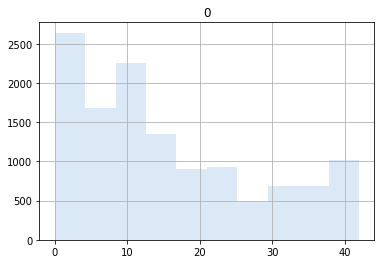

In [8]:
y_test_df = pd.DataFrame(data['y_test'])
y_test_df.head()
y_test_df.hist()

In [9]:
for key, val in data

SyntaxError: invalid syntax (<ipython-input-9-e5dfb8aa180f>, line 1)

In [10]:
#train_data_df = pd.DataFrame(data)

Distributions of features:

Change below code to be made - convert to dataframe to plot feature distribution. Can always use dict stored data moving forward if preferable, but would be nice to reuse code below from mod4 

AttributeError: 'dict' object has no attribute 'columns'

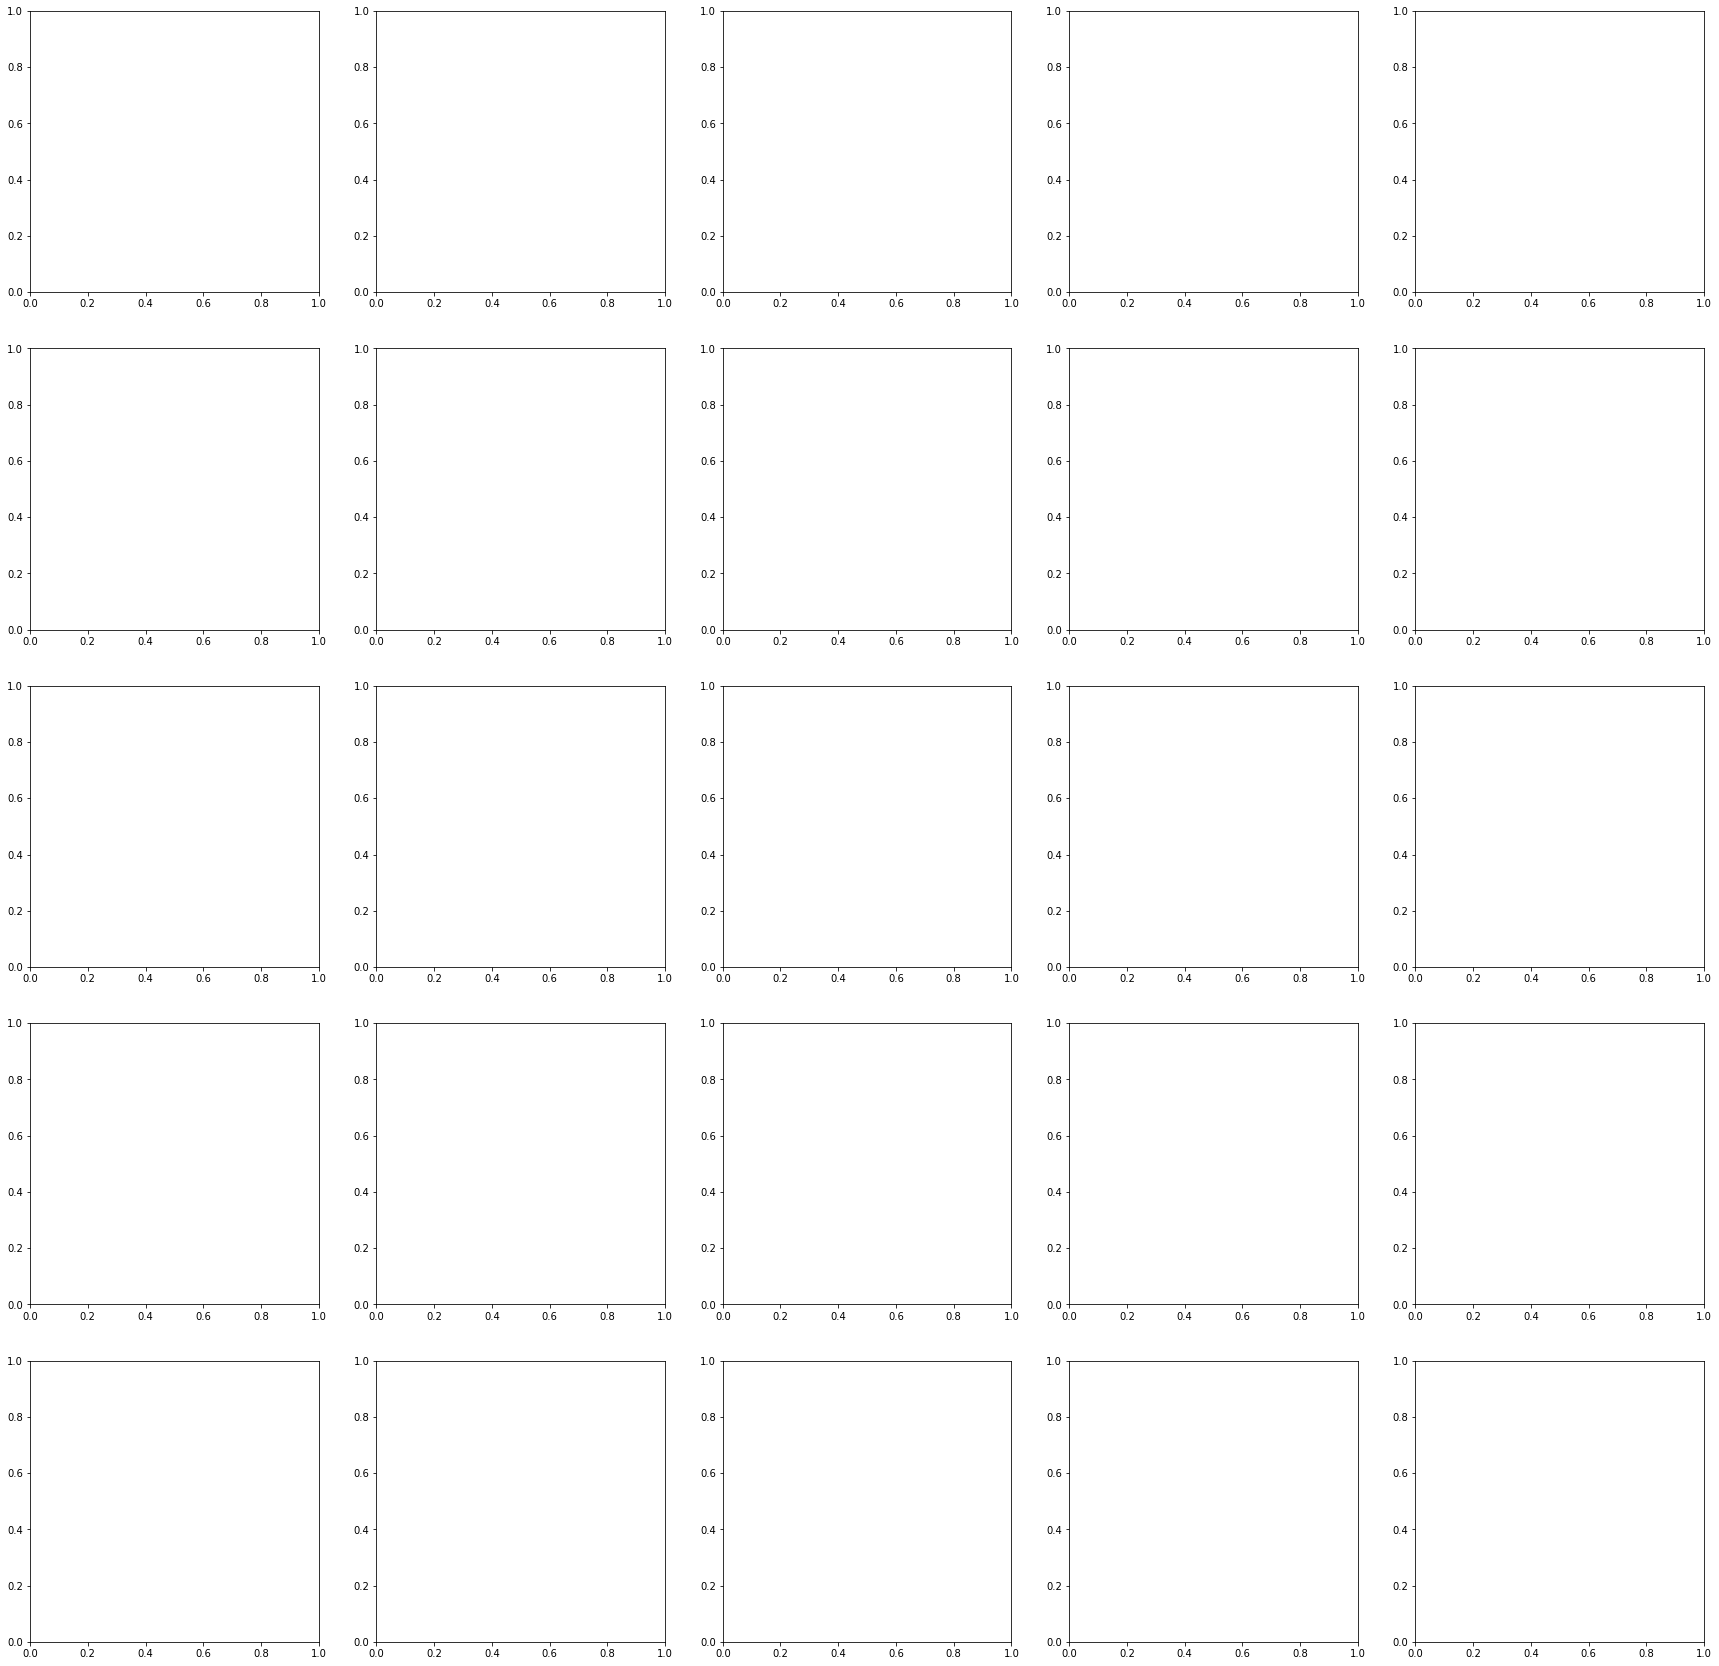

In [11]:
this, that = plt.subplots(5, 5, figsize=(30, 30))
for index, ax in enumerate(that.flatten()):
   column = data.columns[index]
   ax.hist(data[column], bins=20)
   ax.set_title(column)
   ax.legend()
plt.tight_layout(h_pad=1.5)
plt.show()

In [ ]:
def convert_to_grid(x_input):
    N, H, W, C = x_input.shape
    grid_size = int(ceil(sqrt(N)))
    grid_height = H * grid_size + 1 * (grid_size - 1)
    grid_width = W * grid_size + 1 * (grid_size - 1)
    grid = np.zeros((grid_height, grid_width, C)) + 255
    next_idx = 0
    y0, y1 = 0, H
    for y in range(grid_size):
        x0, x1 = 0, W
        for x in range(grid_size):
            if next_idx < N:
                img = x_input[next_idx]
                low, high = np.min(img), np.max(img)
                grid[y0:y1, x0:x1] = 255.0 * (img - low) / (high - low)
                next_idx += 1
            x0 += W + 1
            x1 += W + 1
        y0 += H + 1
        y1 += H + 1

    return grid


# Visualizing some examples of training data
examples = data['x_train'][:81, :, :, :]
print(examples.shape)  # (81, 32, 32, 3)

# Plotting
fig = plt.figure()
grid = convert_to_grid(examples)
plt.imshow(grid.astype('uint8'), cmap='Blues')
plt.axis('off')
plt.gcf().set_size_inches(15, 15)
plt.title('Training Data - Examples:', fontsize=18)
plt.show()
#plt.close()

# Saving plot
#fig.savefig('training_examples.png')
#plt.close()

In [12]:
len(label_names_df) # This is what I should need for softmax output shape

43

In [15]:
# Quick One:
model = Sequential()
model.add(Conv2D(32, kernel_size=3, padding='same', activation='relu', input_shape=(32, 32, 3)))
model.add(MaxPool2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500, activation='relu'))
model.add(Dense(43, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

W1017 22:01:03.435941 4591179200 deprecation_wrapper.py:119] From /Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1017 22:01:03.456099 4591179200 deprecation_wrapper.py:119] From /Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [16]:
history = model.fit(
      x = data['x_train'][:15], 
      y = data['y_train'][:15],
      batch_size=5,
      epochs=10,
      validation_data=(data['x_validation'], data['y_validation']))

W1017 22:01:42.158311 4591179200 deprecation.py:323] From /Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W1017 22:01:42.209894 4591179200 deprecation_wrapper.py:119] From /Users/paulw/anaconda3/envs/learn-env/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 15 samples, validate on 4410 samples
Epoch 1/10
15/15 [==============================] - 2s 156ms/step - loss: 3.9423 - acc: 0.0000e+00 - val_loss: 4.6468 - val_acc: 0.0345
Epoch 2/10
15/15 [==============================] - 2s 126ms/step - loss: 2.1495 - acc: 0.3333 - val_loss: 6.3962 - val_acc: 0.0372
Epoch 3/10
15/15 [==============================] - 2s 126ms/step - loss: 1.5399 - acc: 0.4667 - val_loss: 8.0990 - val_acc: 0.0404
Epoch 4/10
15/15 [==============================] - 2s 128ms/step - loss: 1.0456 - acc: 0.6667 - val_loss: 9.4976 - val_acc: 0.0379
Epoch 5/10
15/15 [==============================] - 2s 127ms/step - loss: 0.9261 - acc: 0.7333 - val_loss: 10.5357 - val_acc: 0.0186
Epoch 6/10
15/15 [==============================] - 2s 126ms/step - loss: 0.6749 - acc: 0.8000 - val_loss: 11.3940 - val_acc: 0.0156
Epoch 7/10
15/15 [==============================] - 2s 128ms/step - loss: 0.5918 - acc: 0.9333 - val_loss: 12.1460 - val_acc: 0.0136
Epoch 8/10
15/15 [=====

In [17]:
# Fit Model:

model_test = models.Sequential()
model_test.add(layers.Conv2D(32, (3, 3), activation='relu',
                        input_shape=(32, 32, 3)))
model_test.add(layers.MaxPooling2D((2, 2)))
model_test.add(layers.Conv2D(32, (3, 3), activation='relu'))
model_test.add(layers.Conv2D(128, (3, 3), activation='relu'))
model_test.add(layers.MaxPooling2D((2, 2)))
model_test.add(layers.Flatten())
model_test.add(layers.Dense(64, activation='relu'))
#model.add(layers.Dense(128, activation='relu'))
#model.add(layers.Dense(256, activation='relu'))
model_test.add(layers.Dense(32, activation='relu'))
model_test.add(layers.Dense(43, activation='softmax'))

In [18]:
model_test.compile(loss='categorical_crossentropy', optimizer='adam', \
              metrics=['acc'])

In [ ]:
history = model_test.fit(
      x = data['x_train'][:5000], 
      y = data['y_train'][:5000],
      batch_size=5,
      epochs=128,
      validation_data=(data['x_validation'], data['y_validation']))

Train on 5000 samples, validate on 4410 samples
Epoch 1/128
5000/5000 [==============================] - 8s 2ms/step - loss: 3.2448 - acc: 0.1234 - val_loss: 2.3290 - val_acc: 0.3213
Epoch 2/128
5000/5000 [==============================] - 8s 2ms/step - loss: 1.5996 - acc: 0.5184 - val_loss: 1.0640 - val_acc: 0.6399
Epoch 3/128
5000/5000 [==============================] - 8s 2ms/step - loss: 0.7308 - acc: 0.7706 - val_loss: 0.7445 - val_acc: 0.7542
Epoch 4/128
5000/5000 [==============================] - 8s 2ms/step - loss: 0.4392 - acc: 0.8556 - val_loss: 0.6705 - val_acc: 0.7925
Epoch 5/128
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2961 - acc: 0.9086 - val_loss: 0.4802 - val_acc: 0.8490
Epoch 6/128
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2182 - acc: 0.9316 - val_loss: 0.5591 - val_acc: 0.8433
Epoch 7/128
5000/5000 [==============================] - 8s 2ms/step - loss: 0.1943 - acc: 0.9424 - val_loss: 0.4755 - val_acc: 0.8678
Epoch 8

5000/5000 [==============================] - 11s 2ms/step - loss: 0.0434 - acc: 0.9928 - val_loss: 1.3805 - val_acc: 0.8653
Epoch 61/128
5000/5000 [==============================] - 12s 2ms/step - loss: 0.0760 - acc: 0.9880 - val_loss: 1.0141 - val_acc: 0.9023
Epoch 62/128
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0680 - acc: 0.9884 - val_loss: 0.8840 - val_acc: 0.9129
Epoch 63/128
5000/5000 [==============================] - 13s 3ms/step - loss: 0.1000 - acc: 0.9850 - val_loss: 1.1213 - val_acc: 0.8905
Epoch 64/128
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0731 - acc: 0.9870 - val_loss: 0.9877 - val_acc: 0.9018
Epoch 65/128
5000/5000 [==============================] - 13s 3ms/step - loss: 0.0393 - acc: 0.9950 - val_loss: 0.7199 - val_acc: 0.9188
Epoch 66/128
5000/5000 [==============================] - 14s 3ms/step - loss: 0.0643 - acc: 0.9900 - val_loss: 0.7622 - val_acc: 0.9118
Epoch 67/128
5000/5000 [==============================

In [ ]:
# ask Victor = this works, but typically I have used Dataframes in the past. Is there any reason it defaults to 
# Storing these as dictionaries? I was curious from an implementation standpoint if one is more efficient.

In [ ]:
history = model.fit(
      x = data['x_train'][:15], 
      y = data['y_train'][:15],
      batch_size=5,
      epochs=10,
      validation_data=(data['x_validation'], data['y_validation']))